### An example of Bayesian analysis for A/B test data. ###

Reference: Bayesian Data Analysis, A. Gelman, A. Vehtari, and D. Rubin 

Imagine that we are doing some A/B test, we will split our data into control group and exposed group so that we have comparison. The exposed group can be a new design of our website and we would like to see if it results in more conversions for example, or it can be a new algorithm we developed and we would like to see if the new algorithm generates better outcome. The control group corresponds to wahtever our baseline system is. In addition to the control-exposed split, we also have split in time, which seperates the time point before we apply the change and after we apply the change. 

A typical (and sometimes naive) way to analyze this type of setup is to look at the before-after change in the exposed group. If we observe on average 10% change in our metric, one might simply conclude that the exposed treatment results in 10% imprvement. However, it's better to also look at the control group to see how does the baseline fare. If the baseline group experiences on average 20% improvement for whatever reason (most likely due to seasonality,) the exposed treatment actually results in worse performance. 

In the following, we will look at the before-after percentage change in the control and exposed groups, respectively. And then compare these two groups. This can be applied to different metrics, as in most practical scenarios we are interested in multiple KPIs. 

We will fit a simple Bayesian linear regression on our data:
\begin{equation}
\% change \sim a + b * treatment,
\end{equation}
where $\% change$ represents the before-after percentage change in a given metric, and treatment is a categorical variable, 0 for control group and 1 for exposed group. In this formula, $a$, the intercept of the linear model, stands for the percentage change we see in the control (baseline) group, and the slope $b$ tells us in the presence of exposed treatment, how much more (or less) change do we observe. 

Since we are doing Bayesian regression, $a$ and $b$ will be distributions, instead of point estimates. This is useful as we can use the distribution of $b$ to infer how strong is the effect of the exposed treatment and whether the treatment is positive or negative. 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import scipy.stats
from bambi import Model
import pymc3 as pm

import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
from plot_functions import adjustAxeProperties

The following parametersdescribe an experiment setup. Typically in a practical scenario, the system will have multiple silos, for example, countries, geo locations, audiences, customer groups, marketing campaigns, etc. When we do control-exposed split, it's better do apply this type of split across multple silos so that our results won't be interpreted as being only specific to a given silo. The number of  silos will be regresented by the "N_GROUPS" variable below. For each silo, we randomly determine how many subgroups will have baseline treatment, and how many of them will have exposed treatment. The concept of a "subgroup" is the subset of the system where the treatment actually takes place. 


In [4]:
N_GROUPS = 5
N_SUBGROUPS = (3, 9)    # min, max
METRICS = (20.0, 50.0)  # min, max
STD = (1.0, 4.0)        # min, max

In [5]:
def dropInfAndNA(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    return df

In [6]:
def generateOneGroup(group_idx, n_metrics=3):
    data_df = []
    n_offset = 0
    for treatment in ['control', 'exposed']:
        n_ = np.random.randint(N_SUBGROUPS[0], N_SUBGROUPS[1])
        for time_period in ['before', 'after']:            
            metrics_dict = {}
            for i in range(n_metrics):
                mean = np.random.uniform(METRICS[0], METRICS[1])
                std = np.random.uniform(STD[0], STD[1])
                metrics_dict['metric{0:}'.format(i+1)] = np.random.normal(loc=mean, scale=std, size=n_)
                
            sub_groups = ['subgroup_{0:}'.format(n_offset+i+1) for i in range(n_)]    
            df = pd.DataFrame({'sub_group': sub_groups, 
                               'treatment': [treatment] * n_, 
                               'time_period': [time_period] * n_,
                               'metric1': metrics_dict['metric1'],
                               'metric2': metrics_dict['metric2'],
                               'metric3': metrics_dict['metric3']})    
            df['group'] = 'group_{0:}'.format(group_idx)
            df = df[['group', 'sub_group', 'treatment', 'time_period', 'metric1', 'metric2', 'metric3']]
            data_df.append(df)
        n_offset += n_
    data_df = pd.concat(data_df, axis=0).reset_index(drop=True)
    return data_df

In [83]:
np.random.seed(3756)
data = []
for i in range(N_GROUPS):
    df = generateOneGroup(i+1)
    data.append(df)
data = pd.concat(data, axis=0).reset_index(drop=True)

In [84]:
data.head(7)

,group,sub_group,treatment,time_period,metric1,metric2,metric3
0,group_1,subgroup_1,control,before,35.318741,39.491882,40.415695
1,group_1,subgroup_2,control,before,41.973011,47.682531,40.424173
2,group_1,subgroup_3,control,before,32.890508,37.221259,42.276147
3,group_1,subgroup_4,control,before,38.144835,41.224499,45.148851
4,group_1,subgroup_5,control,before,40.486393,34.869047,34.437747
5,group_1,subgroup_6,control,before,44.795376,34.441844,43.745367
6,group_1,subgroup_7,control,before,33.551578,38.865498,42.805925


In [85]:
agg = data.set_index(['time_period', 'group', 'sub_group', 'treatment']).unstack(0)

In [86]:
agg.head(7)

metric1               metric2             \
time_period                        after     before      after     before   
group   sub_group   treatment                                               
group_1 subgroup_1  control    45.165469  35.318741  46.368505  39.491882   
        subgroup_10 exposed    34.448990  21.914227  49.773247  45.212982   
        subgroup_11 exposed    42.781992  21.319475  54.578341  40.431887   
        subgroup_12 exposed    35.118051  19.148482  50.540661  37.672012   
        subgroup_13 exposed    34.877127  21.463660  54.170618  41.335662   
        subgroup_14 exposed    35.496693  18.219614  50.687014  48.260989   
        subgroup_15 exposed    35.470641  19.042275  54.541895  39.869833   

                                 metric3             
time_period                        after     before  
group   sub_group   treatment                        
group_1 subgroup_1  control    45.333480  40.415695  
        subgroup_10 exposed    25.543443  24.613244  
        subgroup_11 exposed    21.845656  26.293227  
        subgroup_12 exposed    18.305314  20.704849  
        subgroup_13 exposed    20.714327  21.139065  
        subgroup_14 exposed    23.302331  25.225827  
        subgroup_15 exposed    23.363542  25.842640

The following code block will calculate the before-after percentage change in multiple metrics in control and exposed groups, respectively. 

In [87]:
comp = {}
for metric in ['metric1', 'metric2', 'metric3']:
    tmp = 100 * (agg.loc[:, pd.IndexSlice[metric, 'after']] -  agg.loc[:, pd.IndexSlice[metric, 'before']]) / agg.loc[:, pd.IndexSlice[metric, 'before']]
    tmp = dropInfAndNA(tmp)
    tmp = tmp.reset_index().rename(columns={0: metric})
    comp[metric] = tmp

In [93]:
def plotBeforeAfterChange(data, pct_change_df, metric):
    data['id'] = data['group'] + '_' + data['sub_group']
    
    FONTSIZE = 22
    plt.close('all')
    fig = plt.figure(figsize=(24, 10))
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[0.5, 1])

    ax = plt.subplot(gs[0, 0]) 
    list_of_ids = data['id'].unique()
    for id in list_of_ids:
        df = data[(data['id'] == id) & (data['treatment'] == 'exposed')]
        if len(df) != 2:
            continue
        before_value = df[df['time_period'] == 'before'][metric].values[0]
        after_value = df[df['time_period'] == 'after'][metric].values[0]
        ax.plot([0, 1], [before_value, after_value], marker='.', markersize='15')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['before', 'after'])
    ax.set_title('Exposed group', fontsize=FONTSIZE)        
    ax.set_xlabel('', fontsize=0, labelpad=15)    
    ax.set_ylabel(metric, fontsize=FONTSIZE, labelpad=15)
    adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)

    ax = plt.subplot(gs[0, 1])
    df = pct_change_df
    ax = sbn.distplot(df[df['treatment'] == 'control'][metric], label='control', ax=ax)
    ax = sbn.distplot(df[df['treatment'] == 'exposed'][metric], label='exposed', ax=ax)
    ax.legend(loc='best', fontsize=FONTSIZE)
    ax.set_xlabel('% change in {0:}'.format(metric), fontsize=FONTSIZE, labelpad=15)    
    ax.set_ylabel('Frequency', fontsize=FONTSIZE, labelpad=15)
    adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
    plt.tight_layout(pad=0, w_pad=4.0, h_pad=1.0)    
    

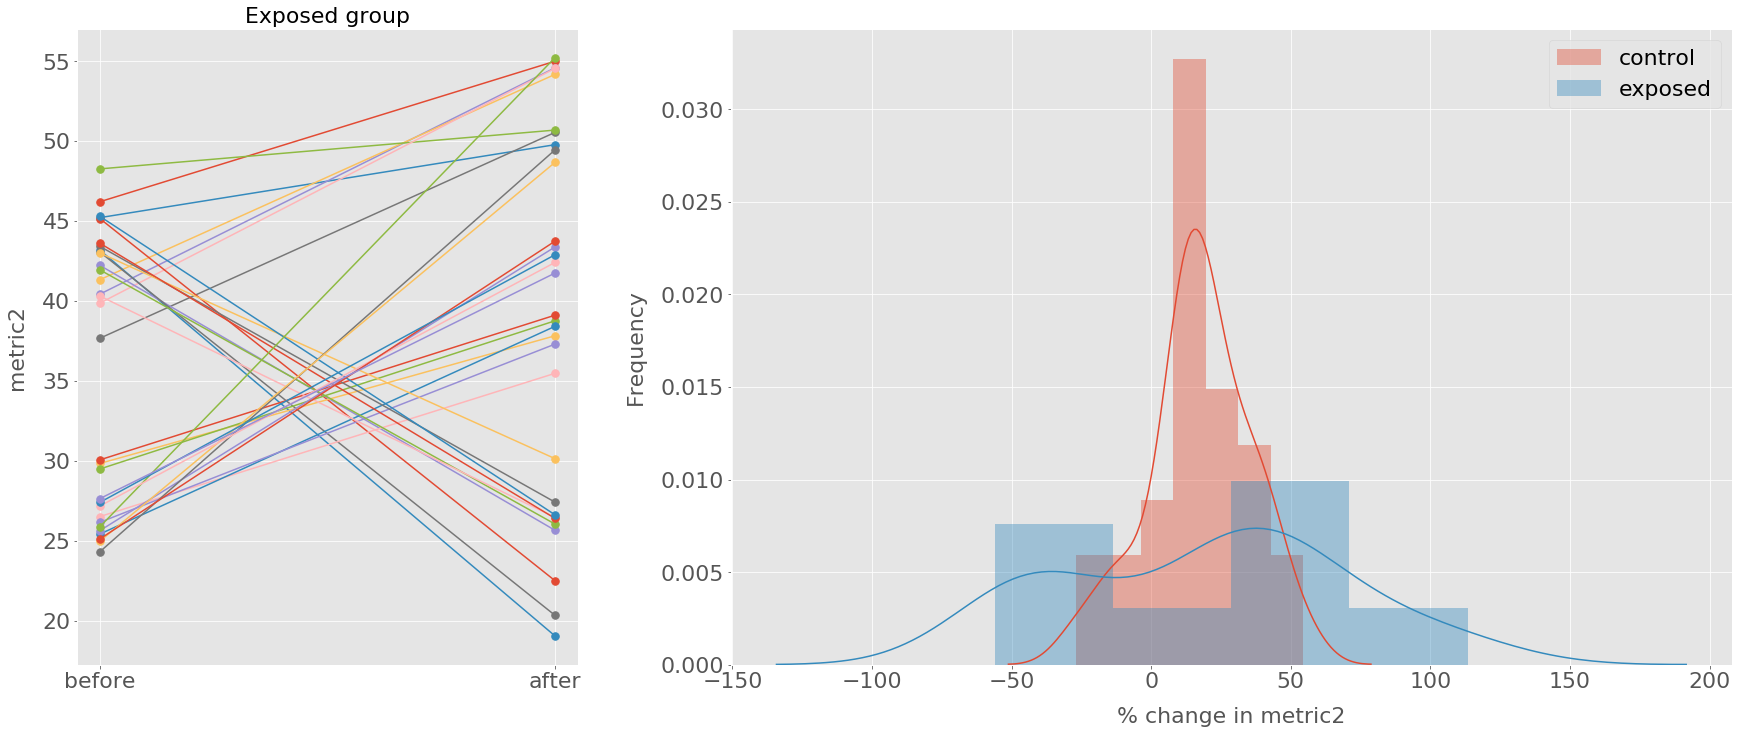

In [94]:
plotBeforeAfterChange(data, comp['metric2'], 'metric2')

The plot on the left shows that some subgroups with the exposed treatment show positive improvements, and some negative. The plot on the right shows the histogram of improvements in the control and exposed groups, respectively. The distribution of the exposed group is more widespread, extending to both negative and higher positive ends. While the distribution of the control group is more certain to be positive, with a smaller magnitude.

So although the exposed distribution extends to higher positive ends, its uncertainty is also higher so that we can not say for sure whether the exposed treatment results in a positive effect. 

This is where the Bayesian approach becomes useful in telling us a better story, as the following analysis shows. 

In [32]:
# Fit a Bayesian linear regression. 
# Alternative to the simple formula described above, we will add a group-specific random effect
# to account for some fluctuation that's specific to the silo.
def BayesianAnalysis(data_df, metric):
    
    WARMUP_STEPS = 100
    SAMPLING_STEPS = 1000
    TOTAL_STEPS = WARMUP_STEPS + SAMPLING_STEPS
    
    model = Model(data_df)
    results = model.fit('{0:} ~ treatment'.format(metric), random=['1|group'], samples=TOTAL_STEPS)
    # results = model.fit('{0:} ~ treatment'.format(metric), samples=TOTAL_STEPS)
    
    mcmc_trace = model.backend.trace[WARMUP_STEPS:]
    
    FONTSIZE = 20
    plt.close('all')
    axes = pm.traceplot(mcmc_trace)
    
    ax = axes[0][0]
    ax.set_title('intercept', fontsize=FONTSIZE)
    
    ax = axes[1][0]
    ax.set_title('slope', fontsize=FONTSIZE)
    
    slope_samples = mcmc_trace['treatment'][:, 0]
    P_positive = slope_samples[slope_samples > 0].size / slope_samples.size
    treatment_kde = scipy.stats.gaussian_kde(slope_samples)
    x_max = np.max(slope_samples)
    x_values = np.linspace(0, x_max, 300)
    y_values = treatment_kde.pdf(x_values)
    ax.fill_between(x_values, y_values, color='r', alpha=0.3, label='P(slope > 0)={0:.3f}'.format(P_positive))
    
    ax.axvline(np.median(slope_samples), color='k', ls='--')
    ax.annotate('median={0:.2f}'.format(np.median(slope_samples)),
                xy=(np.median(slope_samples), 0.0),
                xytext=(0.2, 0.4),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='k', shrink=0.1, width=0.2),
                horizontalalignment='left',
                verticalalignment='bottom',
                fontsize=16)                
    ax.legend(loc='best')
    
    ax= axes[0][1]
    ax.set_title('MCMC samples for interept', fontsize=FONTSIZE)

    ax= axes[1][1]
    ax.set_title('MCMC samples for slope', fontsize=FONTSIZE)

    f = axes[0][0].figure
    f.subplots_adjust(top=0.9)
    f.suptitle('percenrage change in {0:} ~ intercept + treatment'.format(metric), fontsize=FONTSIZE)
    f.savefig('mcmc_plot_{0:}.png'.format(metric))

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = 293.45:  23%|██▎       | 11711/50000 [00:06<00:19, 1919.51it/s]
Convergence archived at 11800
INFO:pymc3.variational.inference:Convergence archived at 11800
Interrupted at 11,799 [23%]: Average Loss = 318.24
INFO:pymc3.variational.inference:Interrupted at 11,799 [23%]: Average Loss = 318.24
100%|██████████| 1600/1600 [00:07<00:00, 222.82it/s]


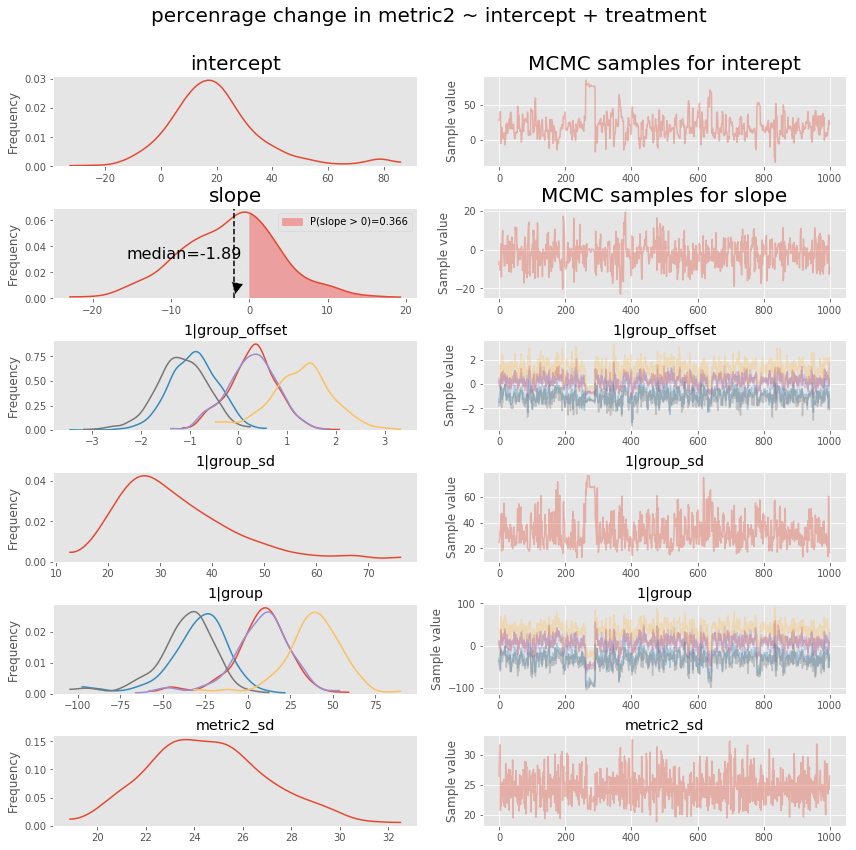

In [92]:
BayesianAnalysis(comp['metric2'], 'metric2')

The above result shows that the control group has roughly 16% before-after percentage change (median of the distribution of the intercept), but the expoed group has some negative effect in the before-after percentage change, resulting in the slope 63% of the time falling on the negative side and having a median on -1.9. This means that the percentage-change in the exposed group will be roughly 1.9 percentage point lower than that in the control group.
